In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental import preprocessing

LOAD DATA FROM AFPDB

In [4]:
import pathlib
font_csvs =  [str(p) for p in pathlib.Path('preproc_data/afpdb').glob("*.csv")]
train_csvs = font_csvs[0:40]+font_csvs[50:90]
test_csvs = font_csvs[40:50]+font_csvs[90:100]
afpdb_train_labels = np.array([0]*40*60+[1]*40*60)
afpdb_test_labels = np.array([0]*10*60+[1]*10*60)
print("AFPDB - Train labels size: ", afpdb_train_labels.size)
print("AFPDB - Test labels size:  ", afpdb_test_labels.size)

AFPDB - Train labels size:  4800
AFPDB - Test labels size:   1200


In [5]:
afpdb_train_data = np.array([])
for csv in train_csvs:
    data = pd.read_csv(csv, header=None)
    for c in range(data.shape[1]):
        row = np.array([np.array([data.iloc[:, c]])])
        if afpdb_train_data.shape[0] == 0:
            afpdb_train_data = row
        else:
            afpdb_train_data = np.vstack((afpdb_train_data, row))
afpdb_train_data = np.moveaxis(afpdb_train_data, 1, 2)
print("AFPDB - Train data shape: ", afpdb_train_data.shape)

AFPDB - Train data shape:  (4800, 900, 1)


In [6]:
afpdb_test_data = np.array([])
for csv in test_csvs:
    data = pd.read_csv(csv, header=None)
    for c in range(data.shape[1]):
        row = np.array([np.array([data.iloc[:, c]])])
        if afpdb_test_data.shape[0] == 0:
            afpdb_test_data = row
        else:
            afpdb_test_data = np.vstack((afpdb_test_data, row))
afpdb_test_data = np.moveaxis(afpdb_test_data, 1, 2)
print("AFPDB - Test data shape: ", afpdb_test_data.shape)

AFPDB - Test data shape:  (1200, 900, 1)


LOAD DATA FROM AFDB

In [7]:
afdb_csvs =  [str(p) for p in pathlib.Path('preproc_data/afdb').glob("*.csv")]
afdb_data = np.array([])
for csv in afdb_csvs:
    data = pd.read_csv(csv, header=None)
    for c in range(data.shape[1]):
        row = np.array([np.array([data.iloc[:, c]])])
        if afdb_data.shape[0] == 0:
            afdb_data = row
        else:
            afdb_data = np.vstack((afdb_data, row))
afdb_data = np.moveaxis(afdb_data, 1, 2)
print("AFDB data shape: ", afdb_data.shape)

AFDB data shape:  (3419, 900, 1)


In [8]:
import math
TEST_PROP = 0.8
index_split = math.ceil(afdb_data.shape[0] * TEST_PROP)
afdb_train = afdb_data[:index_split,:,:]
afdb_test = afdb_data[index_split:,:,:]
print("AFDB - Train data shape: ", afdb_train.shape)
print("AFDB - Test data shape:  ", afdb_test.shape)

AFDB - Train data shape:  (2736, 900, 1)
AFDB - Test data shape:   (683, 900, 1)


In [9]:
afdb_train_labels = np.array([1]*afdb_train.shape[0])
afdb_test_labels = np.array([1]*afdb_test.shape[0])
train_labels = np.concatenate((afpdb_train_labels, afdb_train_labels))
test_labels = np.concatenate((afpdb_test_labels, afdb_test_labels))
print("Total - Train labels size: ", train_labels.size)
print("Total - Test labels size:  ", test_labels.size)

Total - Train labels size:  7536
Total - Test labels size:   1883


In [10]:
train_data = np.concatenate((afpdb_train_data, afdb_train))
test_data = np.concatenate((afpdb_test_data, afdb_test))
print("Total - Train data shape: ", train_data.shape)
print("Total - Test data shape: ", test_data.shape)

Total - Train data shape:  (7536, 900, 1)
Total - Test data shape:  (1883, 900, 1)


LOAD DATA FROM NSRDB

In [11]:
nsrdb_csvs =  [str(p) for p in pathlib.Path('preproc_data/nsrdb').glob("*.csv")]
nsrdb_data = np.array([])
for csv in nsrdb_csvs:
    data = pd.read_csv(csv, header=None)
    for c in range(data.shape[1]):
        row = np.array([np.array([data.iloc[:, c]])])
        if nsrdb_data.shape[0] == 0:
            nsrdb_data = row
        else:
            nsrdb_data = np.vstack((nsrdb_data, row))
nsrdb_data = np.moveaxis(nsrdb_data, 1, 2)
print("NSRDB data shape: ", nsrdb_data.shape)

NSRDB data shape:  (3420, 900, 1)


In [12]:
index_split = math.ceil(nsrdb_data.shape[0] * TEST_PROP)
nsrdb_train = nsrdb_data[:index_split,:,:]
nsrdb_test = nsrdb_data[index_split:,:,:]
print("NSRDB - Train data shape: ", nsrdb_train.shape)
print("NSRDB - Test data shape:  ", nsrdb_test.shape)

NSRDB - Train data shape:  (2736, 900, 1)
NSRDB - Test data shape:   (684, 900, 1)


In [13]:
nsrdb_train_labels = np.array([0]*nsrdb_train.shape[0])
nsrdb_test_labels = np.array([0]*nsrdb_test.shape[0])
train_labels2 = np.concatenate((train_labels, nsrdb_train_labels))
test_labels2 = np.concatenate((test_labels, nsrdb_test_labels))
print("Total - Train labels size: ", train_labels2.size)
print("Total - Test labels size:  ", test_labels2.size)

Total - Train labels size:  10272
Total - Test labels size:   2567


In [14]:
train_data2 = np.concatenate((train_data, nsrdb_train))
test_data2 = np.concatenate((test_data, nsrdb_test))
print("Total - Train data shape: ", train_data2.shape)
print("Total - Test data shape:  ", test_data2.shape)

Total - Train data shape:  (10272, 900, 1)
Total - Test data shape:   (2567, 900, 1)


BUILD DATASET OBJECTS

In [61]:
train = tf.data.Dataset.from_tensor_slices((train_data2, train_labels2))
test = tf.data.Dataset.from_tensor_slices((test_data2, test_labels2))

train = train.shuffle(len(train)).batch(2)
test = test.batch(16)

for d, l in train.take(1):
    print ("Data batch size:   ", d.shape)
    print ("Labels batch size: ", l.shape)

Data batch size:  (2, 900, 1)
Labels batch size:  (2,)


In [13]:
model = models.Sequential()
model.add(layers.BatchNormalization(input_shape=(900,1)))
model.add(layers.Conv1D(16,8))

model.add(layers.MaxPool1D(strides=2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv1D(32,4))
model.add(layers.Conv1D(32,4))
model.add(layers.MaxPool1D(strides=2))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(16, activation='relu'))

model.add(layers.MaxPool1D(strides=2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv1D(32,2))
model.add(layers.Conv1D(32,2))
model.add(layers.MaxPool1D(strides=2))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(8, activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(2))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_5 (Batch (None, 900, 1)            4         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 893, 16)           144       
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 446, 16)           0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 446, 16)           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 443, 32)           2080      
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 440, 32)           4128      
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 220, 32)          

In [63]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

history = model.fit(train, epochs=200,
                       validation_data=(test))

Epoch 1/200
5136/5136 [==============================] - 44s 9ms/step - loss: 0.6446 - accuracy: 0.6199 - val_loss: 0.6301 - val_accuracy: 0.6436
Epoch 2/200
5136/5136 [==============================] - 44s 9ms/step - loss: 0.5437 - accuracy: 0.7309 - val_loss: 0.7107 - val_accuracy: 0.5621
Epoch 3/200
5136/5136 [==============================] - 44s 9ms/step - loss: 0.4965 - accuracy: 0.7598 - val_loss: 0.8937 - val_accuracy: 0.5972
Epoch 4/200
5136/5136 [==============================] - 46s 9ms/step - loss: 0.4700 - accuracy: 0.7771 - val_loss: 0.6668 - val_accuracy: 0.6272
Epoch 5/200
5136/5136 [==============================] - 46s 9ms/step - loss: 0.4418 - accuracy: 0.7992 - val_loss: 0.6362 - val_accuracy: 0.6712
Epoch 6/200
5136/5136 [==============================] - 44s 9ms/step - loss: 0.4211 - accuracy: 0.8078 - val_loss: 0.6632 - val_accuracy: 0.6977
Epoch 7/200
5136/5136 [==============================] - 45s 9ms/step - loss: 0.4146 - accuracy: 0.8143 - val_loss: 0.9026 -

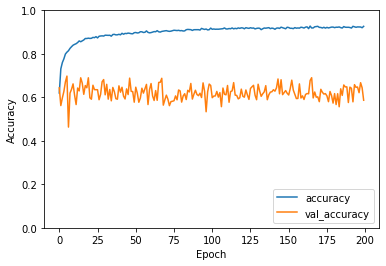

In [64]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [65]:
test_loss, test_acc = model.evaluate(test, verbose=2)

161/161 - 1s - loss: 1.3547 - accuracy: 0.5867
